In [142]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import poisson, loguniform

from sklearn.model_selection import (
    train_test_split, cross_val_score, learning_curve,
    GridSearchCV, RandomizedSearchCV
)
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    classification_report, confusion_matrix, accuracy_score
)

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingRegressor,
    RandomForestClassifier
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeClassifier

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from datetime import datetime
import time


In [143]:
ori_df = pd.read_csv('/content/drive/MyDrive/epl_final.csv')

In [144]:
print(ori_df.shape)

(9380, 22)


In [145]:
for col in ori_df.columns:
    print(col)

Season
MatchDate
HomeTeam
AwayTeam
FullTimeHomeGoals
FullTimeAwayGoals
FullTimeResult
HalfTimeHomeGoals
HalfTimeAwayGoals
HalfTimeResult
HomeShots
AwayShots
HomeShotsOnTarget
AwayShotsOnTarget
HomeCorners
AwayCorners
HomeFouls
AwayFouls
HomeYellowCards
AwayYellowCards
HomeRedCards
AwayRedCards


In [146]:
print(ori_df['Season'].value_counts())

Season
2000/01    380
2001/02    380
2002/03    380
2006/07    380
2005/06    380
2007/08    380
2008/09    380
2010/11    380
2009/10    380
2017/18    380
2018/19    380
2011/12    380
2012/13    380
2013/14    380
2014/15    380
2015/16    380
2016/17    380
2021/22    380
2022/23    380
2019/20    380
2020/21    380
2023/24    380
2024/25    350
2003/04    335
2004/05    335
Name: count, dtype: int64


In [147]:
ori_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9380 entries, 0 to 9379
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Season             9380 non-null   object
 1   MatchDate          9380 non-null   object
 2   HomeTeam           9380 non-null   object
 3   AwayTeam           9380 non-null   object
 4   FullTimeHomeGoals  9380 non-null   int64 
 5   FullTimeAwayGoals  9380 non-null   int64 
 6   FullTimeResult     9380 non-null   object
 7   HalfTimeHomeGoals  9380 non-null   int64 
 8   HalfTimeAwayGoals  9380 non-null   int64 
 9   HalfTimeResult     9380 non-null   object
 10  HomeShots          9380 non-null   int64 
 11  AwayShots          9380 non-null   int64 
 12  HomeShotsOnTarget  9380 non-null   int64 
 13  AwayShotsOnTarget  9380 non-null   int64 
 14  HomeCorners        9380 non-null   int64 
 15  AwayCorners        9380 non-null   int64 
 16  HomeFouls          9380 non-null   int64 


In [148]:
train_df = ori_df[ori_df['Season'] < '2024/25']
test_df = ori_df[ori_df['Season'] == '2024/25']

In [149]:
# Jadwal pertandingan yang ingin ditambahkan
match_schedule = {
    '2025-05-10': [
        ('Fulham', 'Everton'),
        ('Ipswich', 'Brentford'),
        ('Southampton', 'Man City'),
        ('Wolves', 'Brighton'),
        ('AFC Bournemouth', 'Aston Villa'),
    ],
    '2025-05-11': [
        ('Newcastle', 'Chelsea'),
        ('Man Utd', 'West Ham'),
        ('Spurs', 'Crystal Palace'),
        ('Nottingham Forest', 'Leicester'),
        ('Liverpool', 'Arsenal'),
    ],
    '2025-05-17': [
        ('Aston Villa', 'Spurs'),
        ('Chelsea', 'Man Utd'),
    ],
    '2025-05-18': [
        ('Everton', 'Southampton'),
        ('West Ham', 'Nottingham Forest'),
        ('Brentford', 'Fulham'),
        ('Leicester City', 'Ipswich Town'),
        ('Arsenal', 'Newcastle United'),
    ],
    '2025-05-20': [
        ('Brighton', 'Liverpool'),
    ],
    '2025-05-21': [
        ('Crystal Palace', 'Wolves'),
        ('Man City', 'AFC Bournemouth'),
    ],
    '2025-05-25': [
        ('AFC Bournemouth', 'Leicester City'),
        ('Fulham', 'Man City'),
        ('Ipswich Town', 'West Ham'),
        ('Liverpool', 'Crystal Palace'),
        ('Man Utd', 'Aston Villa'),
        ('Newcastle United', 'Everton'),
        ('Nottingham Forest', 'Chelsea'),
        ('Southampton', 'Arsenal'),
        ('Spurs', 'Brighton'),
        ('Wolves', 'Brentford'),
    ]
}

# Buat list untuk menyimpan data pertandingan tambahan
additional_matches_list = []

# Iterasi melalui jadwal pertandingan dan tambahkan ke list
for date_str, matches in match_schedule.items():
    for home_team, away_team in matches:
        additional_matches_list.append({
            'Season': '2024/25',  # Set season for these new matches
            'MatchDate': date_str,
            'HomeTeam': home_team,
            'AwayTeam': away_team
        })

# Konversi list menjadi DataFrame
additional_matches_df = pd.DataFrame(additional_matches_list)


# Gabungkan ke test_df
updated_test_df = pd.concat([test_df, additional_matches_df], ignore_index=True)

# Ubah semua kolom target menjadi None untuk musim 2024/25
cols_to_clear = [
    'FullTimeHomeGoals', 'FullTimeAwayGoals', 'FullTimeResult',
    'HalfTimeHomeGoals', 'HalfTimeAwayGoals', 'HalfTimeResult',
    'HomeShots', 'AwayShots', 'HomeShotsOnTarget', 'AwayShotsOnTarget',
    'HomeCorners', 'AwayCorners', 'HomeFouls', 'AwayFouls',
    'HomeYellowCards', 'AwayYellowCards', 'HomeRedCards', 'AwayRedCards'
]

# Set kolom tersebut menjadi None untuk season 2024/25
updated_test_df.loc[updated_test_df['Season'] == '2024/25', cols_to_clear] = None

In [150]:
drop_col = [
    "HalfTimeHomeGoals", "HalfTimeAwayGoals", "HalfTimeResult",
    "HomeShots", "AwayShots", "HomeShotsOnTarget", "AwayShotsOnTarget",
    "HomeCorners", "AwayCorners", "HomeFouls", "AwayFouls",
    "HomeYellowCards", "AwayYellowCards", "HomeRedCards", "AwayRedCards"
]

# Drop kolom-kolom tersebut dari updated_test_df
updated_test_df.drop(columns=drop_col, inplace=True, errors='ignore')

In [151]:
train_df.to_csv('train_2024_25.csv', index=False)
updated_test_df.to_csv('test_2024_25.csv', index=False)

In [152]:
test_df = pd.read_csv('/content/test_2024_25.csv')
train_df = pd.read_csv('/content/train_2024_25.csv')

In [153]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9030 entries, 0 to 9029
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Season             9030 non-null   object
 1   MatchDate          9030 non-null   object
 2   HomeTeam           9030 non-null   object
 3   AwayTeam           9030 non-null   object
 4   FullTimeHomeGoals  9030 non-null   int64 
 5   FullTimeAwayGoals  9030 non-null   int64 
 6   FullTimeResult     9030 non-null   object
 7   HalfTimeHomeGoals  9030 non-null   int64 
 8   HalfTimeAwayGoals  9030 non-null   int64 
 9   HalfTimeResult     9030 non-null   object
 10  HomeShots          9030 non-null   int64 
 11  AwayShots          9030 non-null   int64 
 12  HomeShotsOnTarget  9030 non-null   int64 
 13  AwayShotsOnTarget  9030 non-null   int64 
 14  HomeCorners        9030 non-null   int64 
 15  AwayCorners        9030 non-null   int64 
 16  HomeFouls          9030 non-null   int64 


In [154]:
train_df.isna().sum()

,0
Season,0
MatchDate,0
HomeTeam,0
AwayTeam,0
FullTimeHomeGoals,0
FullTimeAwayGoals,0
FullTimeResult,0
HalfTimeHomeGoals,0
HalfTimeAwayGoals,0
HalfTimeResult,0


In [155]:
train_df.head()

,Season,MatchDate,HomeTeam,AwayTeam,FullTimeHomeGoals,FullTimeAwayGoals,FullTimeResult,HalfTimeHomeGoals,HalfTimeAwayGoals,HalfTimeResult,...,HomeShotsOnTarget,AwayShotsOnTarget,HomeCorners,AwayCorners,HomeFouls,AwayFouls,HomeYellowCards,AwayYellowCards,HomeRedCards,AwayRedCards
0,2000/01,2000-08-19,Charlton,Man City,4,0,H,2,0,H,...,14,4,6,6,13,12,1,2,0,0
1,2000/01,2000-08-19,Chelsea,West Ham,4,2,H,1,0,H,...,10,5,7,7,19,14,1,2,0,0
2,2000/01,2000-08-19,Coventry,Middlesbrough,1,3,A,1,1,D,...,3,9,8,4,15,21,5,3,1,0
3,2000/01,2000-08-19,Derby,Southampton,2,2,D,1,2,A,...,4,6,5,8,11,13,1,1,0,0
4,2000/01,2000-08-19,Leeds,Everton,2,0,H,2,0,H,...,8,6,6,4,21,20,1,3,0,0


In [156]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Season             380 non-null    object 
 1   MatchDate          380 non-null    object 
 2   HomeTeam           380 non-null    object 
 3   AwayTeam           380 non-null    object 
 4   FullTimeHomeGoals  0 non-null      float64
 5   FullTimeAwayGoals  0 non-null      float64
 6   FullTimeResult     0 non-null      float64
dtypes: float64(3), object(4)
memory usage: 20.9+ KB


In [157]:
test_df.head()

,Season,MatchDate,HomeTeam,AwayTeam,FullTimeHomeGoals,FullTimeAwayGoals,FullTimeResult
0,2024/25,2024-08-16,Man United,Fulham,NaN,NaN,NaN
1,2024/25,2024-08-17,Ipswich,Liverpool,NaN,NaN,NaN
2,2024/25,2024-08-17,Arsenal,Wolves,NaN,NaN,NaN
3,2024/25,2024-08-17,Everton,Brighton,NaN,NaN,NaN
4,2024/25,2024-08-17,Newcastle,Southampton,NaN,NaN,NaN


In [158]:
train_df.describe()

,FullTimeHomeGoals,FullTimeAwayGoals,HalfTimeHomeGoals,HalfTimeAwayGoals,HomeShots,AwayShots,HomeShotsOnTarget,AwayShotsOnTarget,HomeCorners,AwayCorners,HomeFouls,AwayFouls,HomeYellowCards,AwayYellowCards,HomeRedCards,AwayRedCards
count,9030.000000,9030.000000,9030.000000,9030.000000,9030.000000,9030.000000,9030.000000,9030.000000,9030.000000,9030.000000,9030.000000,9030.000000,9030.000000,9030.000000,9030.000000,9030.000000
mean,1.535327,1.173090,0.685050,0.515061,13.611517,10.758583,6.017054,4.710853,6.063787,4.769878,11.293909,11.781063,1.450498,1.777519,0.062237,0.086268
std,1.306002,1.154882,0.833077,0.730447,5.346176,4.663226,3.287012,2.763744,3.105293,2.740115,3.753980,3.936225,1.206426,1.280905,0.252800,0.291990
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,10.000000,7.000000,4.000000,3.000000,4.000000,3.000000,9.000000,9.000000,1.000000,1.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,0.000000,13.000000,10.000000,6.000000,4.000000,6.000000,4.000000,11.000000,12.000000,1.000000,2.000000,0.000000,0.000000
75%,2.000000,2.000000,1.000000,1.000000,17.000000,14.000000,8.000000,6.000000,8.000000,6.000000,14.000000,14.000000,2.000000,3.000000,0.000000,0.000000
max,9.000000,9.000000,5.000000,5.000000,43.000000,31.000000,24.000000,20.000000,20.000000,19.000000,33.000000,29.000000,7.000000,9.000000,3.000000,2.000000


In [159]:
test_df.describe()

,FullTimeHomeGoals,FullTimeAwayGoals,FullTimeResult
count,0.0,0.0,0.0
mean,NaN,NaN,NaN
std,NaN,NaN,NaN
min,NaN,NaN,NaN
25%,NaN,NaN,NaN
50%,NaN,NaN,NaN
75%,NaN,NaN,NaN
max,NaN,NaN,NaN


<ipython-input-160-a7a4e7282a8e>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_df, x='FullTimeResult', palette='Set2')
<ipython-input-160-a7a4e7282a8e>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_df, x='HalfTimeResult', palette='Set1')


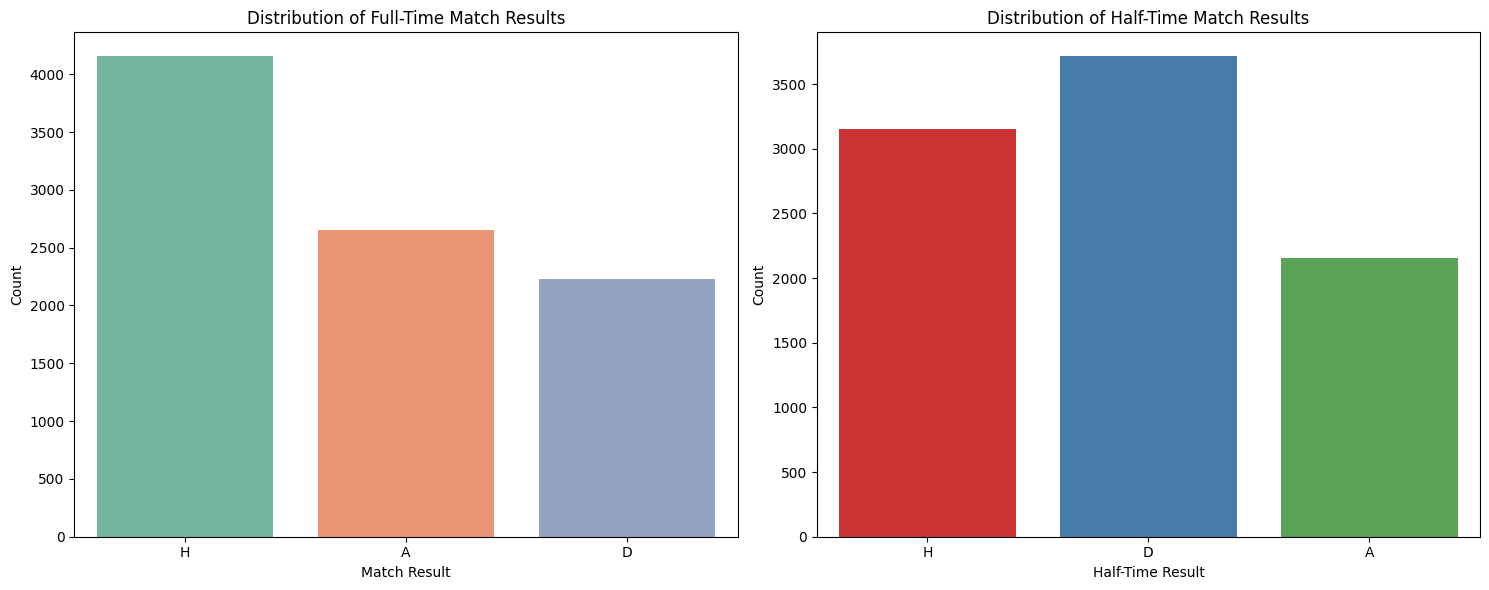

In [160]:
plt.figure(figsize=(15, 6))

# --- Count Plot: FullTimeResult ---
plt.subplot(1, 2, 1)
sns.countplot(data=train_df, x='FullTimeResult', palette='Set2')
plt.title('Distribution of Full-Time Match Results')
plt.xlabel('Match Result')
plt.ylabel('Count')

# --- Count Plot: HalfTimeResult ---
plt.subplot(1, 2, 2)
sns.countplot(data=train_df, x='HalfTimeResult', palette='Set1')
plt.title('Distribution of Half-Time Match Results')
plt.xlabel('Half-Time Result')
plt.ylabel('Count')

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

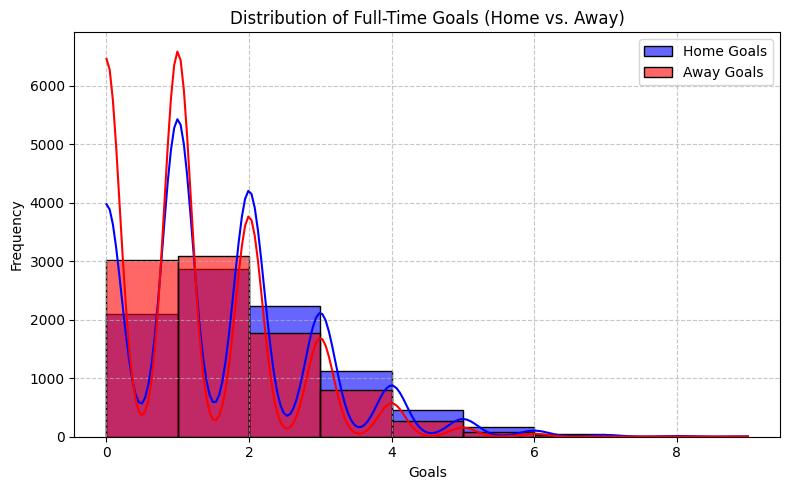

In [161]:
plt.figure(figsize=(8, 5))
sns.histplot(train_df['FullTimeHomeGoals'], color='blue', label='Home Goals', kde=True, bins=range(0, 10), alpha=0.6)
sns.histplot(train_df['FullTimeAwayGoals'], color='red', label='Away Goals', kde=True, bins=range(0, 10), alpha=0.6)
plt.title('Distribution of Full-Time Goals (Home vs. Away)')
plt.xlabel('Goals')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

<ipython-input-162-1759c71d7388>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train_df, x='FullTimeResult', y='FullTimeHomeGoals', palette='Set3')
<ipython-input-162-1759c71d7388>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=ori_df, x='FullTimeResult', y='FullTimeAwayGoals', palette='Set3')


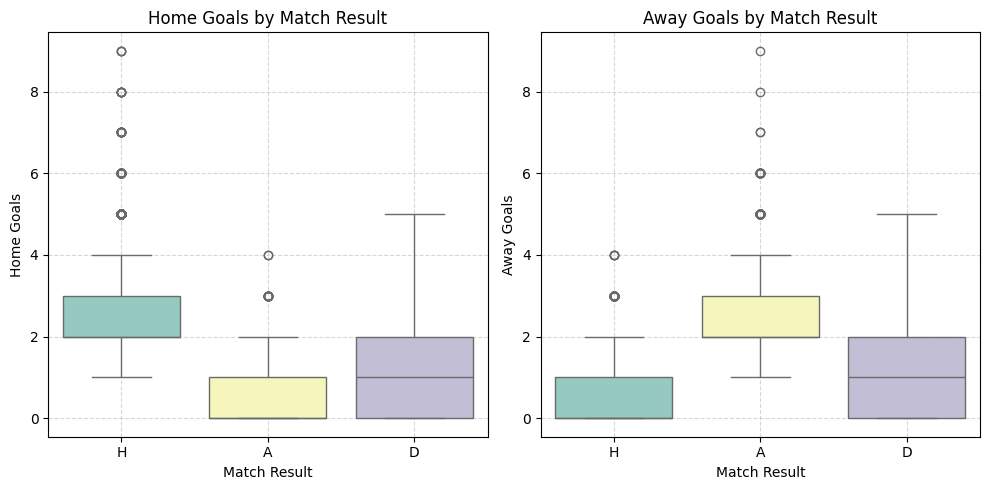

In [162]:
plt.figure(figsize=(10, 5))

# Home Goals Boxplot
plt.subplot(1, 2, 1)
sns.boxplot(data=train_df, x='FullTimeResult', y='FullTimeHomeGoals', palette='Set3')
plt.title('Home Goals by Match Result')
plt.xlabel('Match Result')
plt.ylabel('Home Goals')
plt.grid(True, linestyle='--', alpha=0.5)

# Away Goals Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(data=ori_df, x='FullTimeResult', y='FullTimeAwayGoals', palette='Set3')
plt.title('Away Goals by Match Result')
plt.xlabel('Match Result')
plt.ylabel('Away Goals')
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [163]:
# Filter hanya data pelatihan (tanpa Season 2024/25)
train_df = ori_df[ori_df["Season"] != "2024/25"]

# Pilih fitur numerik untuk analisis outlier
numerical_cols = [
    "FullTimeHomeGoals", "FullTimeAwayGoals", "HalfTimeHomeGoals", "HalfTimeAwayGoals",
    "HomeShots", "AwayShots", "HomeShotsOnTarget", "AwayShotsOnTarget",
    "HomeCorners", "AwayCorners", "HomeFouls", "AwayFouls",
    "HomeYellowCards", "AwayYellowCards", "HomeRedCards", "AwayRedCards"
]

# Hitung statistik outlier: nilai Q1, Q3, dan IQR
outlier_summary = []

for col in numerical_cols:
    Q1 = train_df[col].quantile(0.25)
    Q3 = train_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = train_df[(train_df[col] < lower_bound) | (train_df[col] > upper_bound)][col]
    outlier_summary.append({
        "Fitur": col,
        "Jumlah Outlier": outliers.count(),
        "Persentase Outlier (%)": round(100 * outliers.count() / len(train_df), 2),
        "Nilai Minimum": train_df[col].min(),
        "Nilai Maksimum": train_df[col].max(),
        "Lower Bound": lower_bound,
        "Upper Bound": upper_bound
    })

outlier_df = pd.DataFrame(outlier_summary)
outlier_df.sort_values("Persentase Outlier (%)", ascending=False, inplace=True)

outlier_df

,Fitur,Jumlah Outlier,Persentase Outlier (%),Nilai Minimum,Nilai Maksimum,Lower Bound,Upper Bound
15,AwayRedCards,750,8.31,0,2,0.0,0.0
0,FullTimeHomeGoals,704,7.80,0,9,-0.5,3.5
14,HomeRedCards,538,5.96,0,3,0.0,0.0
12,HomeYellowCards,528,5.85,0,7,-0.5,3.5
9,AwayCorners,323,3.58,0,19,-1.5,10.5
7,AwayShotsOnTarget,319,3.53,0,20,-1.5,10.5
2,HalfTimeHomeGoals,298,3.30,0,5,-1.5,2.5
3,HalfTimeAwayGoals,155,1.72,0,5,-1.5,2.5
6,HomeShotsOnTarget,147,1.63,0,24,-2.0,14.0
11,AwayFouls,129,1.43,1,29,1.5,21.5


<ipython-input-164-5d7b25b6c3da>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['TotalGoals'] = train_df['FullTimeHomeGoals'] + train_df['FullTimeAwayGoals']


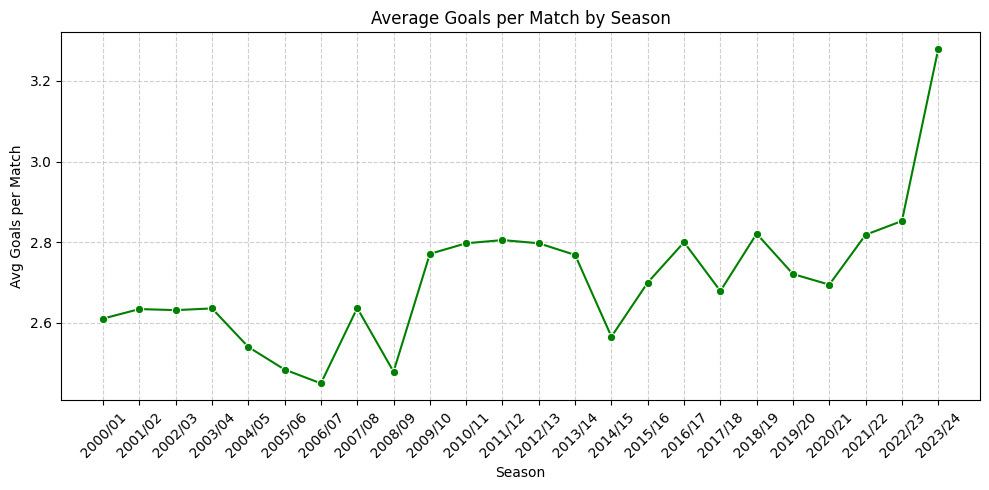

In [164]:
train_df['TotalGoals'] = train_df['FullTimeHomeGoals'] + train_df['FullTimeAwayGoals']
season_goals = train_df.groupby('Season')['TotalGoals'].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.lineplot(data=season_goals, x='Season', y='TotalGoals', marker='o', color='green')
plt.title('Average Goals per Match by Season')
plt.xlabel('Season')
plt.ylabel('Avg Goals per Match')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<ipython-input-165-d1517ab51480>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='FullTimeResult', y=col, data=train_df, palette='Set3')
<ipython-input-165-d1517ab51480>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='FullTimeResult', y=col, data=train_df, palette='Set3')
<ipython-input-165-d1517ab51480>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='FullTimeResult', y=col, data=train_df, palette='Set3')
<ipython-input-165-d1517ab51480>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be re

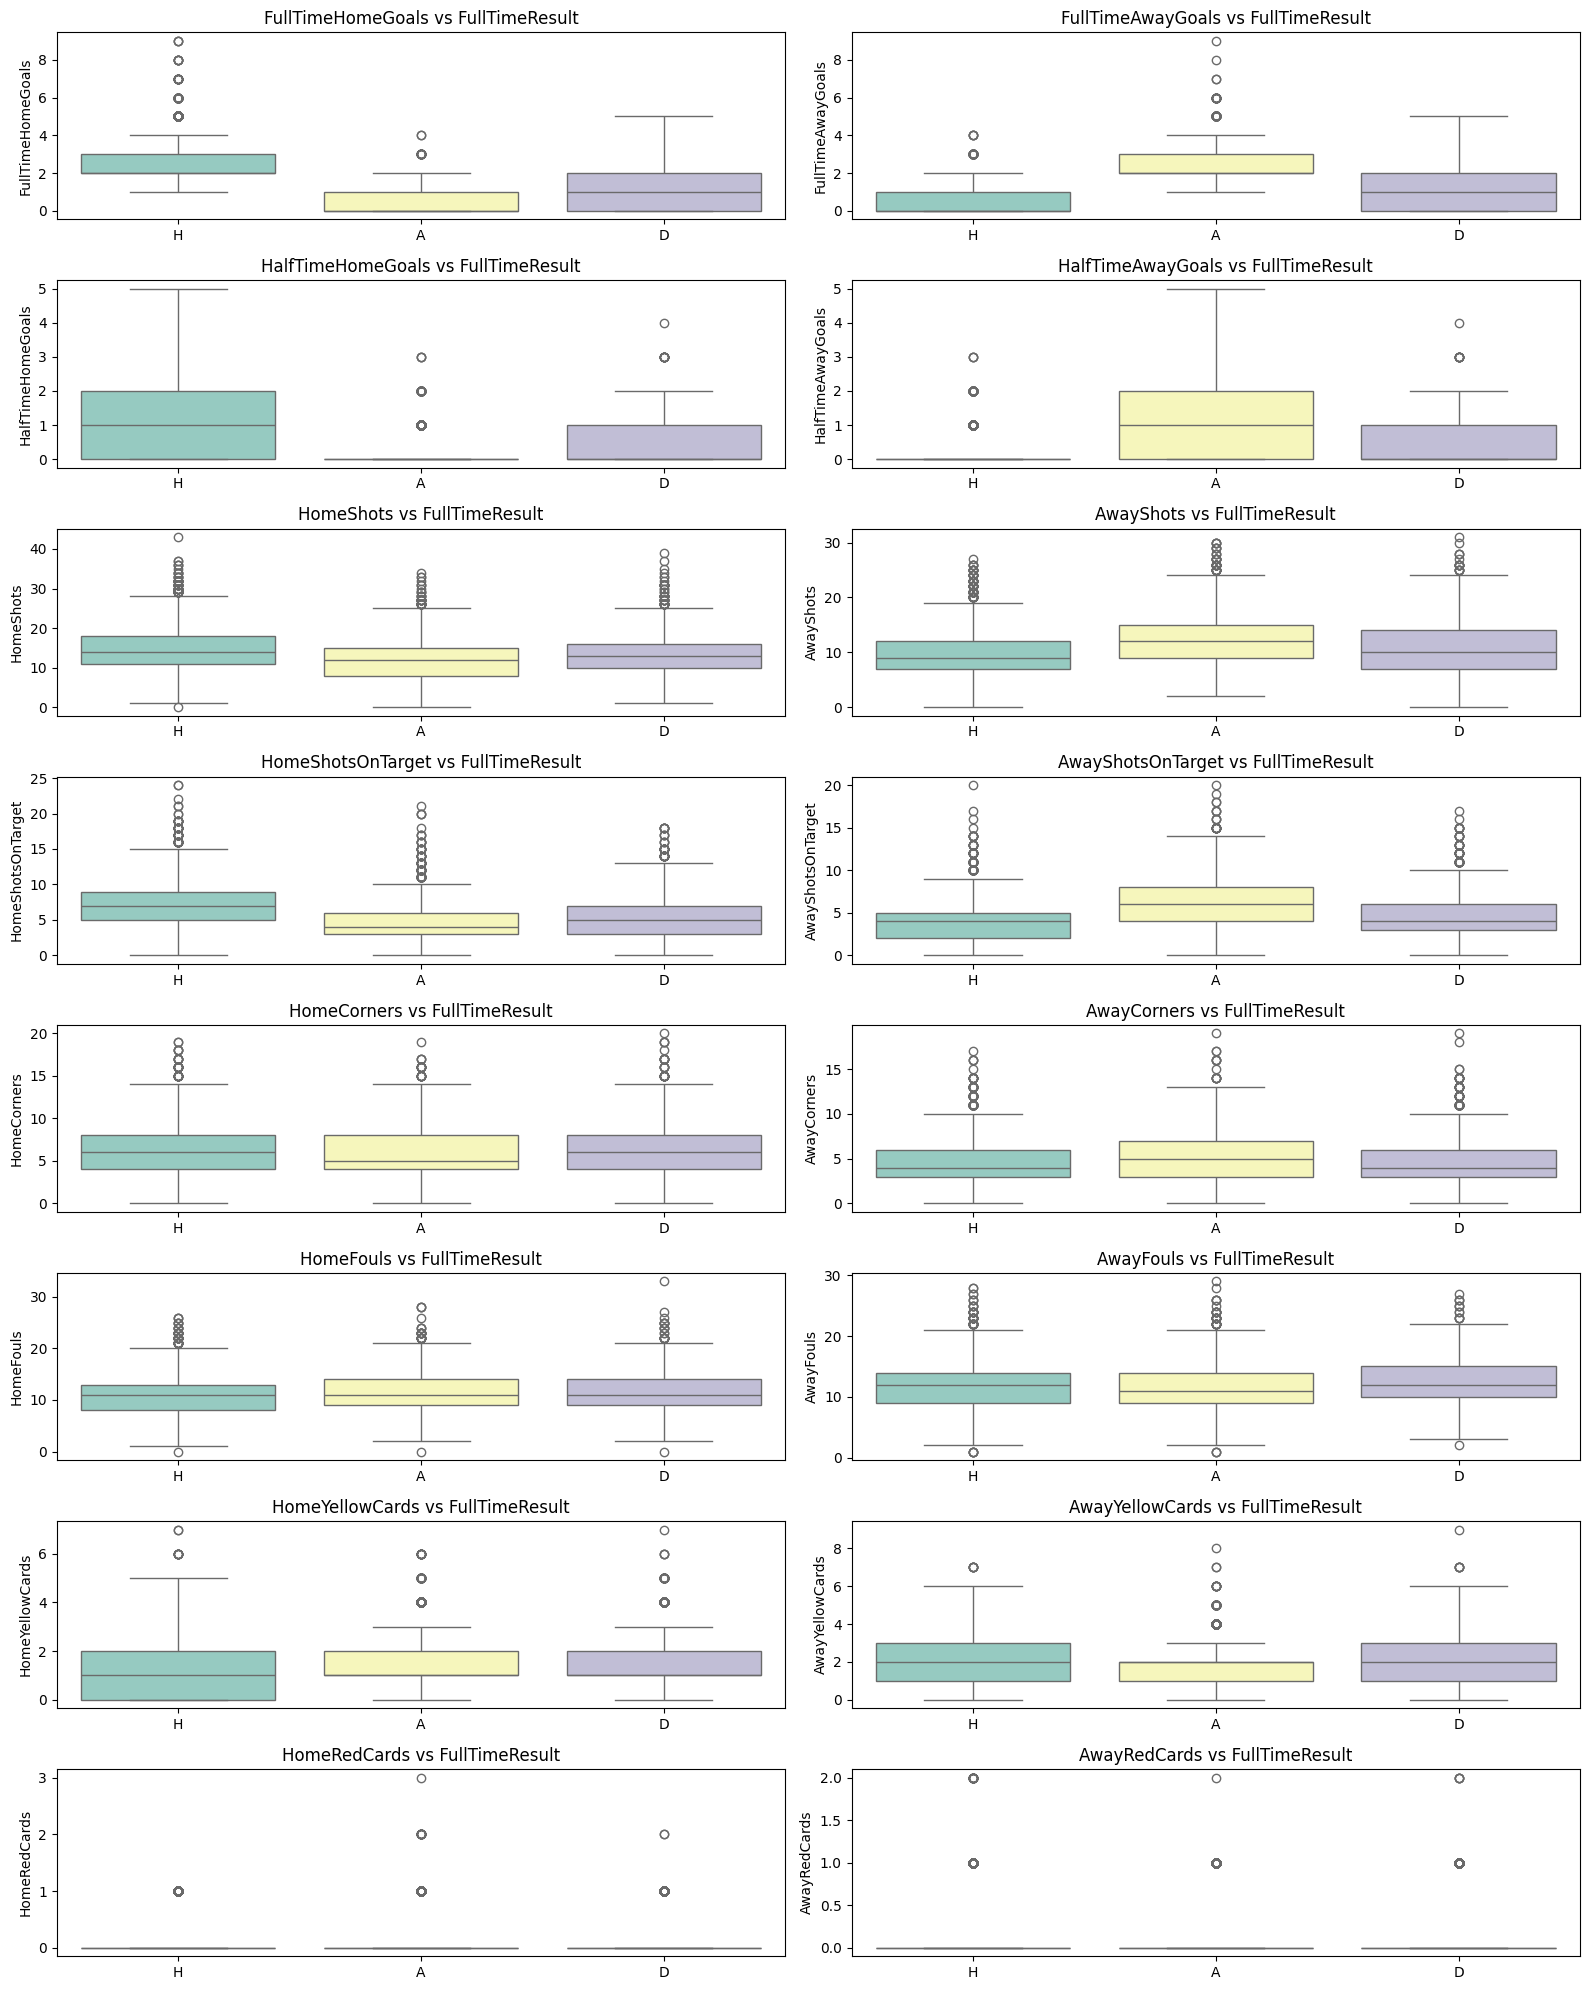

In [165]:
# Buat subset data numerik dan tambahkan kolom target
numerical_features = [
    'FullTimeHomeGoals', 'FullTimeAwayGoals', 'HalfTimeHomeGoals', 'HalfTimeAwayGoals',
    'HomeShots', 'AwayShots', 'HomeShotsOnTarget', 'AwayShotsOnTarget',
    'HomeCorners', 'AwayCorners', 'HomeFouls', 'AwayFouls',
    'HomeYellowCards', 'AwayYellowCards', 'HomeRedCards', 'AwayRedCards'
]

# Boxplot untuk masing-masing fitur numerik terhadap target
plt.figure(figsize=(16, 20))
for i, col in enumerate(numerical_features):
    plt.subplot(8, 2, i + 1)
    sns.boxplot(x='FullTimeResult', y=col, data=train_df, palette='Set3')
    plt.title(f'{col} vs FullTimeResult')
    plt.xlabel('')
    plt.tight_layout()
plt.show()

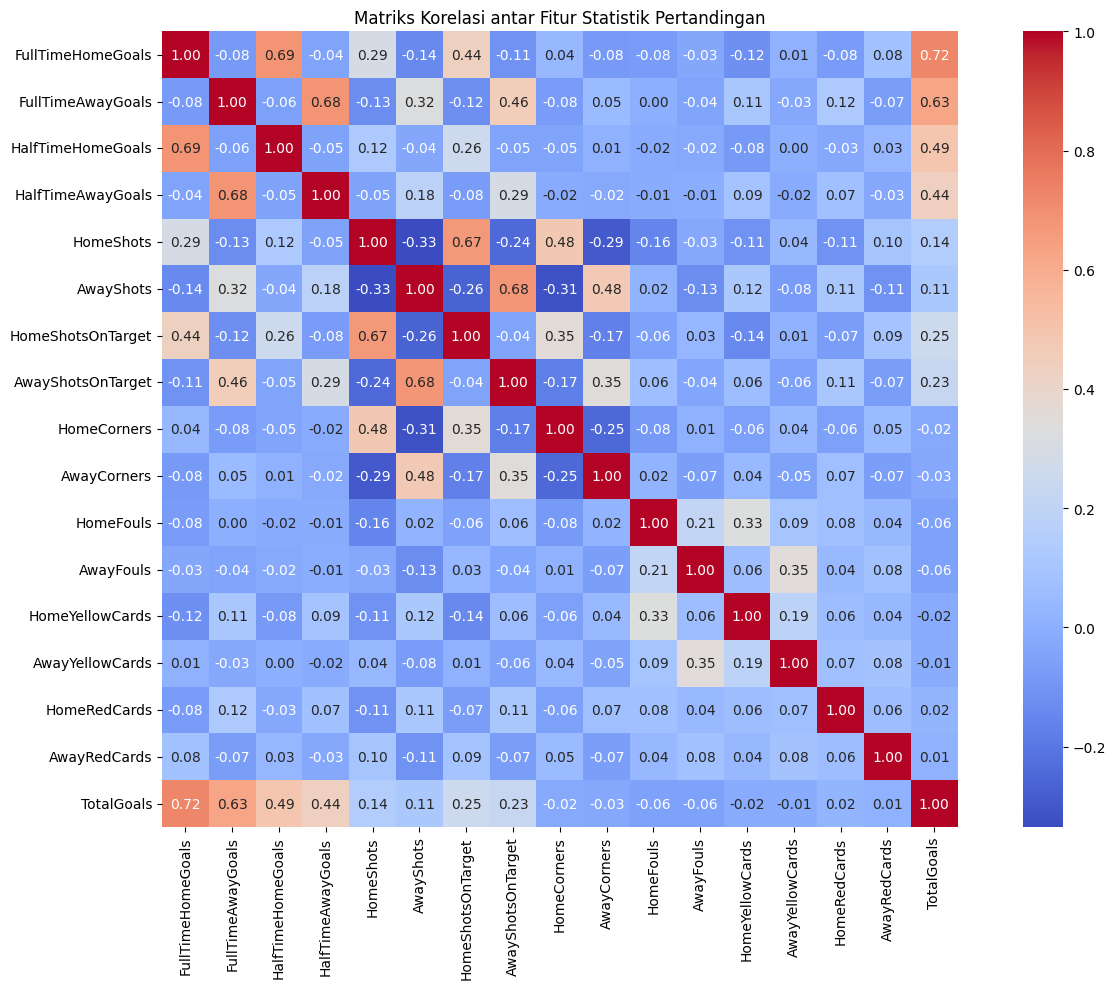

In [166]:
# Hitung korelasi antar fitur numerik
corr_matrix = train_df.select_dtypes(include='number').corr()

# Plot heatmap korelasi
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Matriks Korelasi antar Fitur Statistik Pertandingan")
plt.tight_layout()
plt.show()

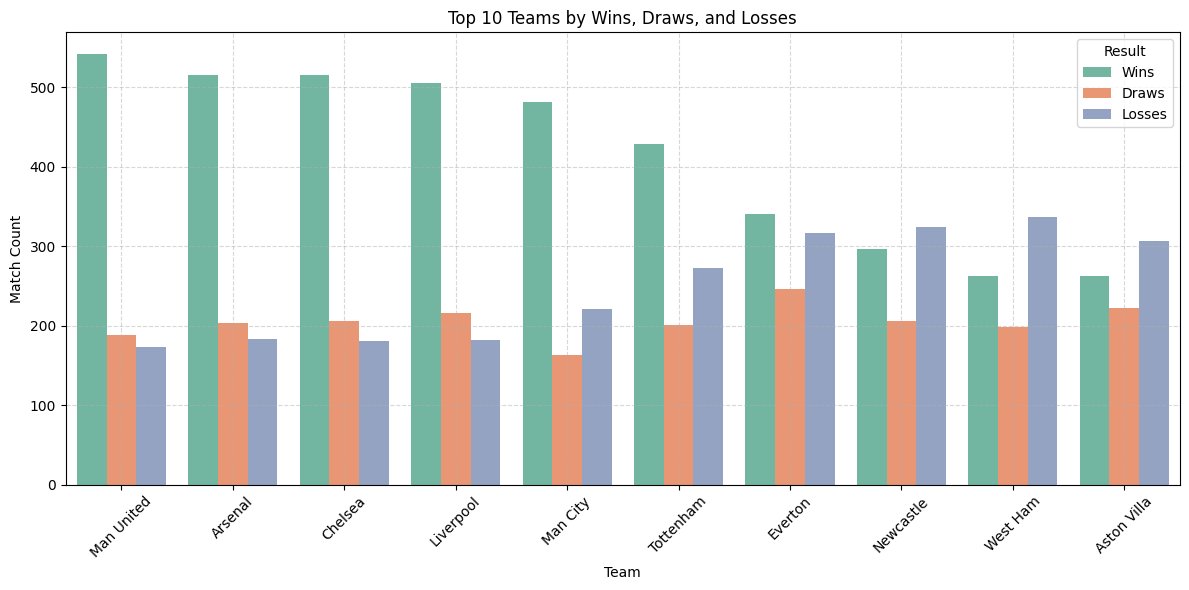

In [167]:
team_results = pd.DataFrame()

# Home Results
home_results = train_df['FullTimeResult'] == 'H'
away_results = train_df['FullTimeResult'] == 'A'
draw_results = train_df['FullTimeResult'] == 'D'

team_results['Wins'] = train_df.loc[home_results, 'HomeTeam'].value_counts() + train_df.loc[away_results, 'AwayTeam'].value_counts()
team_results['Draws'] = train_df.loc[draw_results, 'HomeTeam'].value_counts() + train_df.loc[draw_results, 'AwayTeam'].value_counts()
team_results['Losses'] = train_df.loc[away_results, 'HomeTeam'].value_counts() + train_df.loc[home_results, 'AwayTeam'].value_counts()
team_results = team_results.fillna(0).astype(int).sort_values('Wins', ascending=False).head(10)
train_df
team_results_plot = team_results.reset_index().melt(id_vars='index', value_vars=['Wins', 'Draws', 'Losses'],
                                                     var_name='Result', value_name='Count')
plt.figure(figsize=(12, 6))
sns.barplot(data=team_results_plot, x='index', y='Count', hue='Result', palette='Set2')
plt.title('Top 10 Teams by Wins, Draws, and Losses')
plt.xlabel('Team')
plt.ylabel('Match Count')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

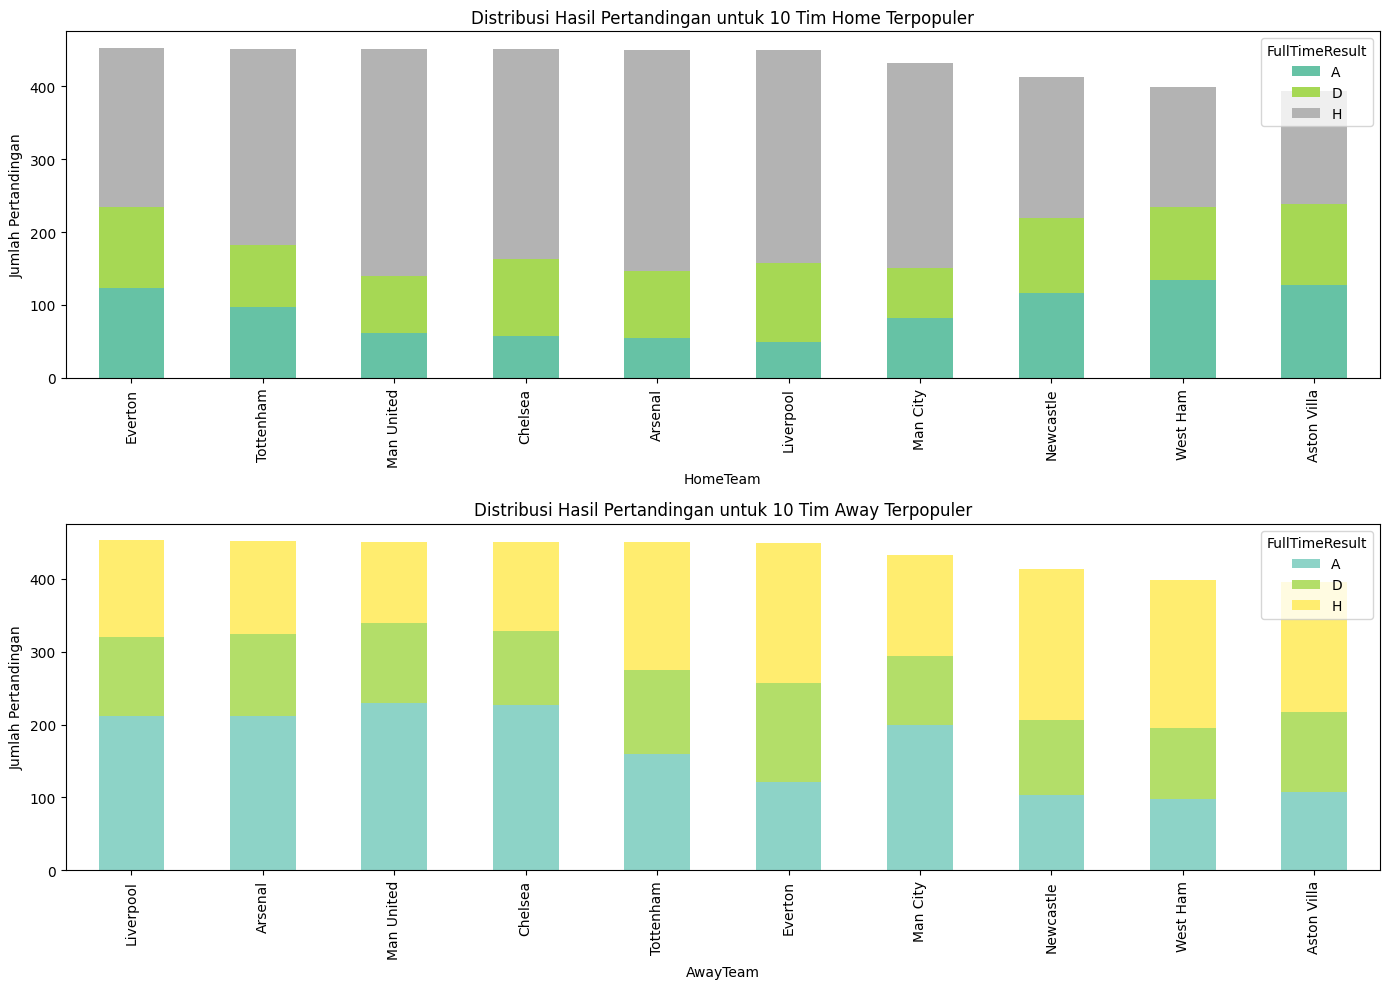

In [168]:
# Cek proporsi hasil pertandingan berdasarkan HomeTeam dan AwayTeam (tim populer)
home_team_result = train_df.groupby(['HomeTeam', 'FullTimeResult']).size().unstack(fill_value=0)
away_team_result = train_df.groupby(['AwayTeam', 'FullTimeResult']).size().unstack(fill_value=0)

# Ambil 10 tim dengan jumlah pertandingan kandang terbanyak
top_home_teams = train_df['HomeTeam'].value_counts().head(10).index
top_away_teams = train_df['AwayTeam'].value_counts().head(10).index

# Filter hanya tim-tim populer
home_team_result_top = home_team_result.loc[top_home_teams]
away_team_result_top = away_team_result.loc[top_away_teams]

# Plot
fig, axes = plt.subplots(2, 1, figsize=(14, 10))
home_team_result_top.plot(kind='bar', stacked=True, ax=axes[0], colormap='Set2')
axes[0].set_title('Distribusi Hasil Pertandingan untuk 10 Tim Home Terpopuler')
axes[0].set_ylabel('Jumlah Pertandingan')
axes[0].legend(title='FullTimeResult')

away_team_result_top.plot(kind='bar', stacked=True, ax=axes[1], colormap='Set3')
axes[1].set_title('Distribusi Hasil Pertandingan untuk 10 Tim Away Terpopuler')
axes[1].set_ylabel('Jumlah Pertandingan')
axes[1].legend(title='FullTimeResult')

plt.tight_layout()
plt.show()

In [169]:
# Atur seed untuk reproduktibilitas
np.random.seed(42)
random.seed(42)

# Fungsi untuk menghasilkan skor acak berbasis Poisson dengan seed
def generate_random_score(lambda_val):
    """Generate random score with Poisson distribution using fixed seed"""
    np.random.seed(42)  # Atur seed di dalam fungsi
    return np.random.poisson(lambda_val)

# Fungsi untuk menghitung probabilitas hasil pertandingan
def calculate_win_probability(home_exp, away_exp):
    """Optimized Poisson probability calculation with vectorization"""
    max_goals = 15
    i, j = np.meshgrid(np.arange(max_goals), np.arange(max_goals))
    prob_matrix = poisson.pmf(i, home_exp) * poisson.pmf(j, away_exp)

    home_win = np.sum(prob_matrix * (i > j))
    draw = np.sum(prob_matrix * (i == j))
    away_win = np.sum(prob_matrix * (i < j))

    total = home_win + draw + away_win + 1e-10
    return home_win/total, draw/total, away_win/total

In [170]:
# Fungsi feature engineering untuk prediksi skor
def feature_engineering_for_scores(df, full_data=None):
    df = df.copy()

    # Konversi tanggal
    df['MatchDate'] = pd.to_datetime(df['MatchDate'])
    df['Month'] = df['MatchDate'].dt.month
    df['DayOfWeek'] = df['MatchDate'].dt.dayofweek
    df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)

    # Jika full_data disediakan (untuk training), hitung statistik tim
    if full_data is not None:
        # Hitung statistik tim sebagai tuan rumah
        home_stats = full_data.groupby('HomeTeam').agg({
            'FullTimeHomeGoals': ['mean', 'std'],
            'FullTimeAwayGoals': ['mean', 'std'],
            'HomeShots': 'mean',
            'HomeShotsOnTarget': 'mean'
        })
        home_stats.columns = ['Home_' + '_'.join(col).strip() for col in home_stats.columns.values]

        # Hitung statistik tim sebagai tamu
        away_stats = full_data.groupby('AwayTeam').agg({
            'FullTimeAwayGoals': ['mean', 'std'],
            'FullTimeHomeGoals': ['mean', 'std'],
            'AwayShots': 'mean',
            'AwayShotsOnTarget': 'mean'
        })
        away_stats.columns = ['Away_' + '_'.join(col).strip() for col in away_stats.columns.values]

        # Gabungkan statistik ke dataframe
        df = df.merge(home_stats, left_on='HomeTeam', right_index=True, how='left')
        df = df.merge(away_stats, left_on='AwayTeam', right_index=True, how='left')

        # Hitung perbedaan statistik
        df['AttackDiff'] = df['Home_FullTimeHomeGoals_mean'] - df['Away_FullTimeAwayGoals_mean']
        df['DefenseDiff'] = df['Home_FullTimeAwayGoals_mean'] - df['Away_FullTimeHomeGoals_mean']

    return df

# Terapkan feature engineering
train_df = feature_engineering_for_scores(train_df, train_df)
test_df = feature_engineering_for_scores(test_df, train_df)

In [171]:
# Kecenderungan tim mencetak gol banyak
train_df['HomeTeam_HighScoring'] = train_df.groupby('HomeTeam')['FullTimeHomeGoals'].transform(lambda x: (x > 2).mean())

In [172]:
# Definisikan fitur dan target
features = [
    'Month', 'DayOfWeek', 'IsWeekend',
    'Home_FullTimeHomeGoals_mean', 'Home_FullTimeHomeGoals_std',
    'Home_FullTimeAwayGoals_mean', 'Home_FullTimeAwayGoals_std',
    'Away_FullTimeAwayGoals_mean', 'Away_FullTimeAwayGoals_std',
    'Away_FullTimeHomeGoals_mean', 'Away_FullTimeHomeGoals_std',
    'AttackDiff', 'DefenseDiff',
    'Home_HomeShots_mean', 'Home_HomeShotsOnTarget_mean',
    'Away_AwayShots_mean', 'Away_AwayShotsOnTarget_mean'
]

# Target untuk prediksi
target_home = 'FullTimeHomeGoals'
target_away = 'FullTimeAwayGoals'

# Pisahkan fitur dan target untuk data training asli (sebelum split evaluasi)
X_train_full = train_df[features].fillna(0)
y_train_home_full = train_df[target_home]
y_train_away_full = train_df[target_away]


# --- Split training data for training and evaluation ---
# This split is for evaluating model performance on historical data.
X_train, X_eval, y_train_home, y_eval_home = train_test_split(
    X_train_full, y_train_home_full, test_size=0.2, random_state=42
)
# Definisikan fitur dan target
features = [
    'Month', 'DayOfWeek', 'IsWeekend',
    'Home_FullTimeHomeGoals_mean', 'Home_FullTimeHomeGoals_std',
    'Home_FullTimeAwayGoals_mean', 'Home_FullTimeAwayGoals_std',
    'Away_FullTimeAwayGoals_mean', 'Away_FullTimeAwayGoals_std',
    'Away_FullTimeHomeGoals_mean', 'Away_FullTimeHomeGoals_std',
    'AttackDiff', 'DefenseDiff',
    'Home_HomeShots_mean', 'Home_HomeShotsOnTarget_mean',
    'Away_AwayShots_mean', 'Away_AwayShotsOnTarget_mean'
]

# Target untuk prediksi
target_home = 'FullTimeHomeGoals'
target_away = 'FullTimeAwayGoals'

# Pisahkan fitur dan target untuk data training asli (sebelum split evaluasi)
X_train_full = train_df[features].fillna(0)
y_train_home_full = train_df[target_home]
y_train_away_full = train_df[target_away]


# --- Split training data for training and evaluation ---
# This split is for evaluating model performance on historical data.
X_train, X_eval, y_train_home, y_eval_home = train_test_split(
    X_train_full, y_train_home_full, test_size=0.2, random_state=42
)

_, _, y_train_away, y_eval_away = train_test_split(
    X_train_full, y_train_away_full, test_size=0.2, random_state=42
)

In [173]:
# Daftar model
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'LightGBM': LGBMRegressor(random_state=42),
    'KNN': KNeighborsRegressor(),
    'SVR': SVR()
}

# Fungsi untuk melatih dan mengevaluasi model
def train_and_evaluate_models(models, X_train, y_train, X_eval, y_eval): # Changed parameter names to X_eval, y_eval
    results = []

    for name, model in models.items():
        # Latih model
        model.fit(X_train, y_train)

        # Prediksi (using evaluation set)
        y_pred_eval = model.predict(X_eval) # Predict on evaluation set

        # Evaluasi (using evaluation set)
        mae = mean_absolute_error(y_eval, y_pred_eval)
        mse = mean_squared_error(y_eval, y_pred_eval)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_eval, y_pred_eval)

        results.append({
            'Model': name,
            'MAE': mae,
            'MSE': mse,
            'RMSE': rmse,
            'R2': r2
        })

    return pd.DataFrame(results)

In [174]:
# Evaluasi model untuk prediksi gol tuan rumah (menggunakan data split evaluasi)
print("Evaluasi Model untuk Prediksi Gol Tuan Rumah:")

# Pass the split evaluation dataframes
home_results = train_and_evaluate_models(models, X_train, y_train_home, X_eval, y_eval_home)
print(home_results.sort_values('RMSE'))

# Evaluasi model untuk prediksi gol tamu (menggunakan data split evaluasi)
print("\nEvaluasi Model untuk Prediksi Gol Tamu:")

# Corrected function name from train_and_evaluate_evaluate_models to train_and_evaluate_models
away_results = train_and_evaluate_models(models, X_train, y_train_away, X_eval, y_eval_away)
print(away_results.sort_values('RMSE'))

Evaluasi Model untuk Prediksi Gol Tuan Rumah:
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1087
[LightGBM] [Info] Number of data points in the train set: 7224, number of used features: 17
[LightGBM] [Info] Start training from score 1.531561
               Model       MAE       MSE      RMSE        R2
0  Linear Regression  0.998904  1.632231  1.277588  0.124478
2  Gradient Boosting  1.004375  1.658163  1.287697  0.110568
6                SVR  0.984754  1.701895  1.304567  0.087110
4           LightGBM  1.040201  1.782790  1.335212  0.043718
5                KNN  1.098893  1.957320  1.399043 -0.049899
3            XGBoost  1.108653  2.003094  1.415307 -0.074452
1      Random Forest  1.125617  2.067460  1.437867 -0.108978

Evaluasi Model untuk Prediksi Gol Tamu:
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing wa

Evaluasi Model untuk Home Gols
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000288 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1087
[LightGBM] [Info] Number of data points in the train set: 5779, number of used features: 17
[LightGBM] [Info] Start training from score 1.527600
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1087
[LightGBM] [Info] Number of data points in the train set: 5779, number of used features: 17
[LightGBM] [Info] Start training from score 1.519294
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true

<ipython-input-175-cb27c1ee01fb>:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='RMSE', y='Model', data=home_results, palette='viridis')
<ipython-input-175-cb27c1ee01fb>:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='RMSE', y='Model', data=away_results, palette='magma')


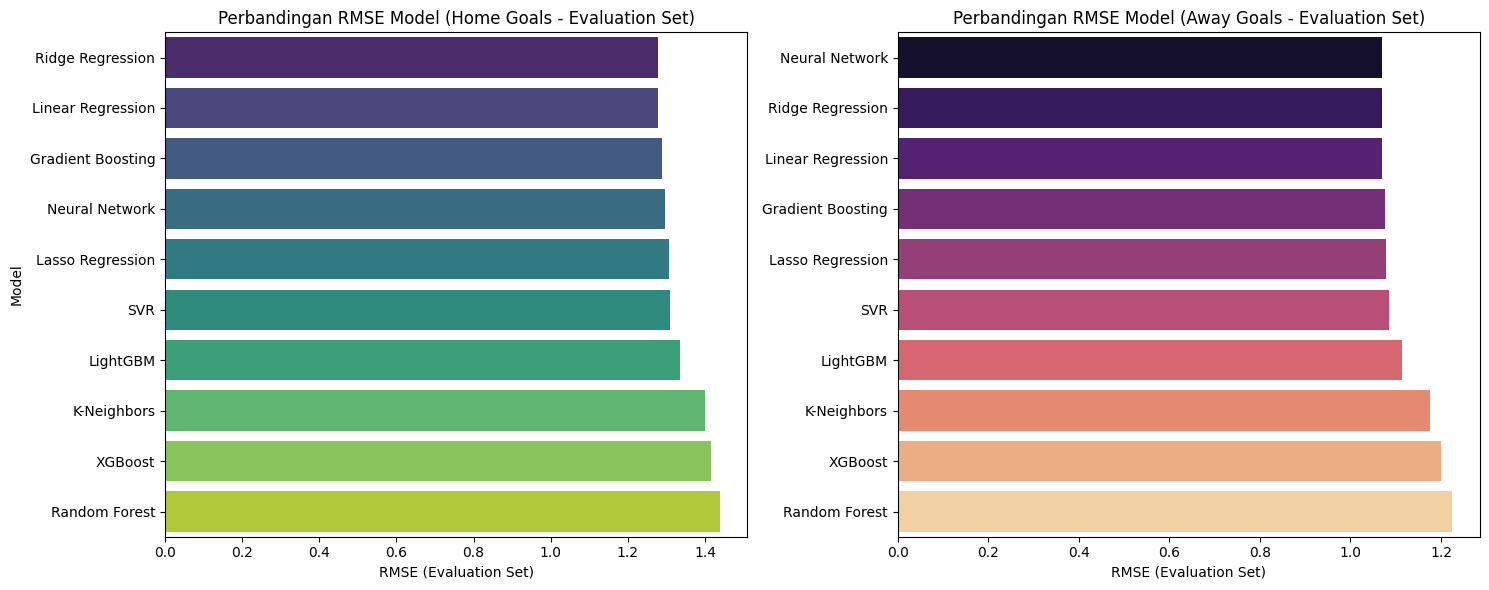

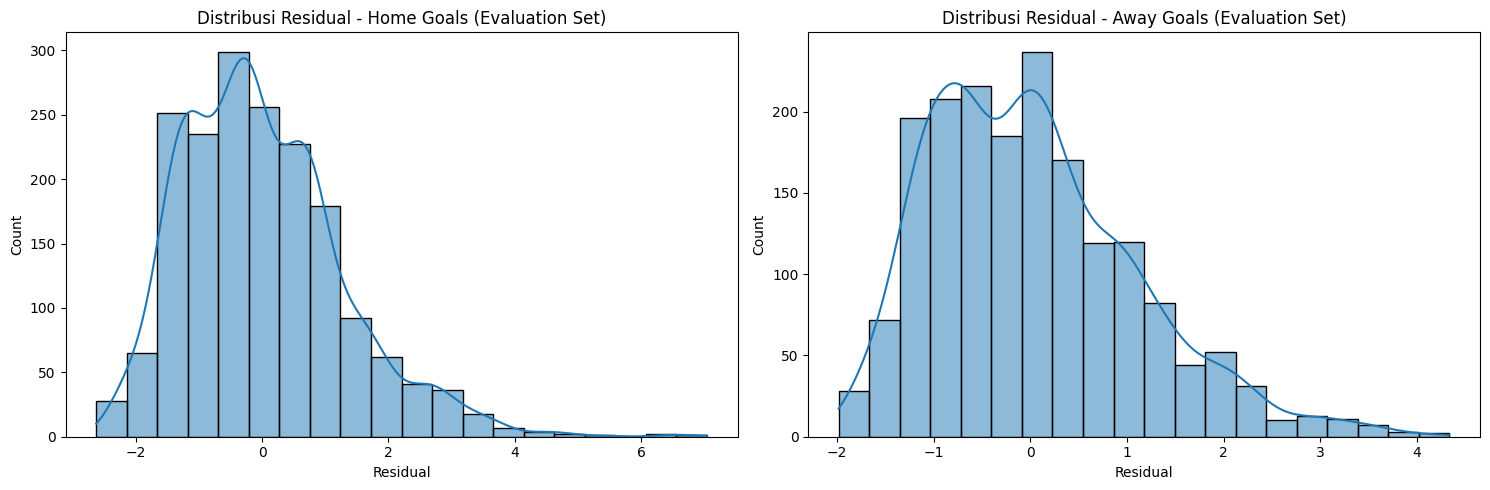


=== MODEL TERBAIK UNTUK HOME GOALS (BERDASARKAN EVALUASI) ===
Model    Ridge Regression
MAE               0.99891
MSE              1.632145
RMSE             1.277554
R2               0.124524
Name: 1, dtype: object

=== MODEL TERBAIK UNTUK AWAY GOALS (BERDASARKAN EVALUASI) ===
Model    Neural Network
MAE            0.845815
MSE            1.145392
RMSE            1.07023
R2             0.094033
Name: 9, dtype: object

Saving the models selected based on evaluation metrics...


In [175]:
# ANALISIS KOMPARATIF MODELING

# Daftar model
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
    'LightGBM': LGBMRegressor(n_estimators=100, random_state=42),
    'SVR': make_pipeline(StandardScaler(), SVR(C=1.0)),
    'K-Neighbors': KNeighborsRegressor(n_neighbors=5),
    'Neural Network': MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
}

# Fungsi untuk evaluasi model
def evaluate_models(models, X_train, y_train, X_eval, y_eval, cv=5):
    results = []

    for name, model in models.items():
        model_start_time = time.time()

        # Cross-validation (using training data)
        cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
        cv_rmse = np.sqrt(-cv_scores)

        # Training model on the training data
        model.fit(X_train, y_train)

        # Prediksi and evaluation on the evaluation data
        y_pred_eval = model.predict(X_eval)

        # Hitung metrics on the evaluation data
        mae = mean_absolute_error(y_eval, y_pred_eval)
        mse = mean_squared_error(y_eval, y_pred_eval)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_eval, y_pred_eval)

        # End time for individual model
        model_end_time = time.time()


        results.append({
            'Model': name,
            'Model': name,
            'MAE': mae,
            'MSE': mse,
            'RMSE': rmse,
            'R2': r2
        })

    return pd.DataFrame(results)

# Evaluasi untuk Home Goals (using evaluation split)
print("Evaluasi Model untuk Home Gols")

home_results = evaluate_models(models, X_train, y_train_home, X_eval, y_eval_home)
home_results = home_results.sort_values('RMSE') # Sort by Eval RMSE
print(home_results)

# Evaluasi untuk Away Goals (using evaluation split)
print("\n Evaluasi Model untuk Away Goals")

away_results = evaluate_models(models, X_train, y_train_away, X_eval, y_eval_away)
away_results = away_results.sort_values('RMSE') # Sort by Eval RMSE
print(away_results)

# Visualisasi Perbandingan Model (using evaluation results)
plt.figure(figsize=(15, 6))

# Plot untuk Home Goals
plt.subplot(1, 2, 1)
# Changed x-axis to Eval RMSE
sns.barplot(x='RMSE', y='Model', data=home_results, palette='viridis')
plt.title('Perbandingan RMSE Model (Home Goals - Evaluation Set)')
plt.xlabel('RMSE (Evaluation Set)')
plt.ylabel('Model')

# Plot untuk Away Goals
plt.subplot(1, 2, 2)
# Changed x-axis to Eval RMSE
sns.barplot(x='RMSE', y='Model', data=away_results, palette='magma')
plt.title('Perbandingan RMSE Model (Away Goals - Evaluation Set)')
plt.xlabel('RMSE (Evaluation Set)')
plt.ylabel('')

plt.tight_layout()
plt.show()

# Analisis Residual (using evaluation split)
best_home_model_eval = models[home_results.iloc[0]['Model']]
best_home_model_eval.fit(X_train, y_train_home)
home_residuals = y_eval_home - best_home_model_eval.predict(X_eval)

best_away_model_eval = models[away_results.iloc[0]['Model']]
best_away_model_eval.fit(X_train, y_train_away)
away_residuals = y_eval_away - best_away_model_eval.predict(X_eval)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.histplot(home_residuals, kde=True, bins=20)
plt.title('Distribusi Residual - Home Goals (Evaluation Set)')
plt.xlabel('Residual')

plt.subplot(1, 2, 2)
sns.histplot(away_residuals, kde=True, bins=20)
plt.title('Distribusi Residual - Away Goals (Evaluation Set)')
plt.xlabel('Residual')

plt.tight_layout()
plt.show()

# Pemilihan Model Terbaik (based on evaluation results)
print("\n=== MODEL TERBAIK UNTUK HOME GOALS (BERDASARKAN EVALUASI) ===")
print(home_results.iloc[0])

print("\n=== MODEL TERBAIK UNTUK AWAY GOALS (BERDASARKAN EVALUASI) ===")
print(away_results.iloc[0])

print("\nSaving the models selected based on evaluation metrics...")

In [176]:
def plot_learning_curve(estimator, title, X, y, cv=5, scoring='neg_root_mean_squared_error'):
    plt.figure(figsize=(8, 6))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring,
        train_sizes=np.linspace(0.1, 1.0, 5), random_state=42
    )

    train_scores_mean = -np.mean(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)

    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score (RMSE)")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score (RMSE)")

    plt.legend(loc="best")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [177]:
best_home_model = Ridge(alpha=1.0)
best_away_model = Ridge(alpha=1.0)
#best_away_model = MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)

# Latih model terbaik menggunakan seluruh data pelatihan (train_df)
best_home_model.fit(X_train_full, y_train_home_full) # Train on the full training dataset
best_away_model.fit(X_train_full, y_train_away_full) # Train on the full training dataset

# Definisikan fitur untuk data test (sesuai dengan fitur yang digunakan saat training)
features = [
    'Month', 'DayOfWeek', 'IsWeekend',
    'Home_FullTimeHomeGoals_mean', 'Home_FullTimeHomeGoals_std',
    'Home_FullTimeAwayGoals_mean', 'Home_FullTimeAwayGoals_std',
    'Away_FullTimeAwayGoals_mean', 'Away_FullTimeAwayGoals_std',
    'Away_FullTimeHomeGoals_mean', 'Away_FullTimeHomeGoals_std',
    'AttackDiff', 'DefenseDiff',
    'Home_HomeShots_mean', 'Home_HomeShotsOnTarget_mean',
    'Away_AwayShots_mean', 'Away_AwayShotsOnTarget_mean'
]

# Extract features from the processed test_df and handle potential missing values
X_test = test_df[features].fillna(0)

# Prediksi pada data test
test_df['PredictedHomeGoals'] = best_home_model.predict(X_test)
test_df['PredictedAwayGoals'] = best_away_model.predict(X_test)

In [178]:
from scipy.stats import poisson

# Simpan prediksi raw
test_df['PredictedHomeGoals_raw'] = best_home_model.predict(X_test)
test_df['PredictedAwayGoals_raw'] = best_away_model.predict(X_test)

# Pastikan mu selalu non-negatif. Menggunakan max(x, 0.1) untuk menghindari nilai <= 0.
np.random.seed(42)
test_df['PredictedHomeGoals'] = test_df['PredictedHomeGoals_raw'].apply(lambda x: poisson.rvs(mu=max(x, 0.1)))
test_df['PredictedAwayGoals'] = test_df['PredictedAwayGoals_raw'].apply(lambda x: poisson.rvs(mu=max(x, 0.1)))

# Hitung probabilitas kemenangan menggunakan distribusi Poisson
from scipy.stats import poisson

# Fungsi untuk menghitung probabilitas hasil pertandingan
def calculate_win_probability(home_exp, away_exp):
    """
    Calculates the probability of home win, draw, and away win
    using the Poisson distribution for expected goals.
    Ensures expected goals are non-negative.
    """
    # Ensure expected goals are non-negative for Poisson PMF calculation
    home_exp = max(home_exp, 0)
    away_exp = max(away_exp, 0)

    home_win, draw, away_win = 0, 0, 0
    max_goals = 10  # Batas maksimal gol yang dihitung

    for i in range(max_goals):  # Home goals
        for j in range(max_goals):  # Away goals
            prob = poisson.pmf(i, home_exp) * poisson.pmf(j, away_exp)
            if i > j:
                home_win += prob
            elif i == j:
                draw += prob
            else:
                away_win += prob

    # Normalisasi
    total = home_win + draw + away_win
    # Add a small epsilon to avoid division by zero if total is 0
    total = total if total > 0 else 1e-9
    return home_win/total, draw/total, away_win/total

# Tambahkan kolom probabilitas
test_df['HomeWinProbability'] = 0.0
test_df['DrawProbability'] = 0.0
test_df['AwayWinProbability'] = 0.0

for idx, row in test_df.iterrows():
    home_prob, draw_prob, away_prob = calculate_win_probability(
        row['PredictedHomeGoals_raw'],
        row['PredictedAwayGoals_raw']
    )
    test_df.at[idx, 'HomeWinProbability'] = round(home_prob, 3)
    test_df.at[idx, 'DrawProbability'] = round(draw_prob, 3)
    test_df.at[idx, 'AwayWinProbability'] = round(away_prob, 3)

# Prediksi hasil akhir
test_df['PredictedFullTime'] = test_df.apply(
    lambda row: 'H' if row['PredictedHomeGoals'] > row['PredictedAwayGoals'] else
               ('A' if row['PredictedAwayGoals'] > row['PredictedHomeGoals'] else 'D'),
    axis=1
)

# Tampilkan hasil prediksi lengkap dengan probabilitas
print(test_df[['HomeTeam', 'AwayTeam',
              'PredictedHomeGoals', 'PredictedAwayGoals', 'PredictedFullTime',
              'HomeWinProbability', 'DrawProbability', 'AwayWinProbability']].head(10))

        HomeTeam        AwayTeam  PredictedHomeGoals  PredictedAwayGoals  \
0     Man United          Fulham                   4                   0   
1        Ipswich       Liverpool                   0                   0   
2        Arsenal          Wolves                   0                   1   
3        Everton        Brighton                   3                   1   
4      Newcastle     Southampton                   2                   2   
5  Nott'm Forest     Bournemouth                   1                   0   
6       West Ham     Aston Villa                   1                   0   
7      Brentford  Crystal Palace                   1                   0   
8        Chelsea        Man City                   1                   4   
9      Leicester       Tottenham                   1                   0   

  PredictedFullTime  HomeWinProbability  DrawProbability  AwayWinProbability  
0                 H               0.716            0.183               0.101  
1    

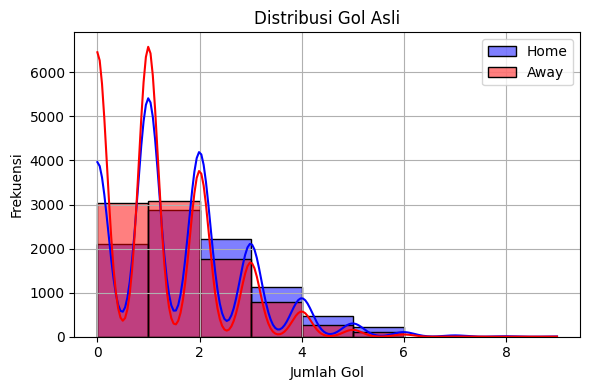

In [179]:
plt.figure(figsize=(6,4))
sns.histplot(train_df['FullTimeHomeGoals'], kde=True, bins=range(0,7), color='blue', label='Home')
sns.histplot(train_df['FullTimeAwayGoals'], kde=True, bins=range(0,7), color='red', label='Away')
plt.title("Distribusi Gol Asli")
plt.xlabel("Jumlah Gol")
plt.ylabel("Frekuensi")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [180]:
# Membuat submission file final
# Ensure submission_df is created before attempting to use it
submission_df = test_df[['Season', 'MatchDate', 'HomeTeam', 'AwayTeam',
                        'PredictedHomeGoals', 'PredictedAwayGoals', 'PredictedFullTime',
                        'HomeWinProbability', 'DrawProbability', 'AwayWinProbability']].copy()

# Analisis tambahan untuk submission
print("\nStatistik Prediksi:")
print(f"Rata-rata gol kandang: {submission_df['PredictedHomeGoals'].mean():.2f}")
print(f"Rata-rata gol tandang: {submission_df['PredictedAwayGoals'].mean():.2f}")
print("\nDistribusi Hasil Prediksi:")
print(submission_df['PredictedFullTime'].value_counts(normalize=True).apply(lambda x: f"{x:.1%}"))


Statistik Prediksi:
Rata-rata gol kandang: 1.46
Rata-rata gol tandang: 1.19

Distribusi Hasil Prediksi:
PredictedFullTime
H    40.3%
A    31.1%
D    28.7%
Name: proportion, dtype: object


=== Ridge Regression Best Params ===
Best RMSE: 1.216
Best Params: {'alpha': 10, 'solver': 'lsqr'}


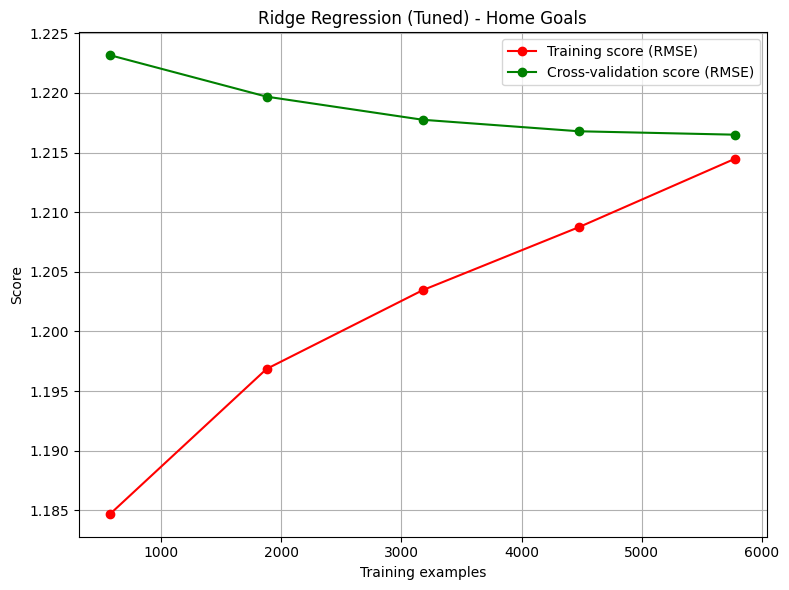

In [181]:
# Definisi parameter space untuk Ridge
ridge_params = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100],  # Kekuatan regularisasi
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}

# Grid Search dengan cross-validation
ridge_search = GridSearchCV(
    Ridge(),
    ridge_params,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)
ridge_search.fit(X_train, y_train_home)

# Hasil terbaik
print("=== Ridge Regression Best Params ===")
print(f"Best RMSE: {-ridge_search.best_score_:.3f}")
print(f"Best Params: {ridge_search.best_params_}")

# Plot learning curve model terbaik
# Corrected the order of arguments: title, X, y
plot_learning_curve(ridge_search.best_estimator_, 'Ridge Regression (Tuned) - Home Goals', X_train, y_train_home)

=== Ridge Regression Best Params ===
Best RMSE: 1.100
Best Params: {'alpha': 10, 'solver': 'lsqr'}


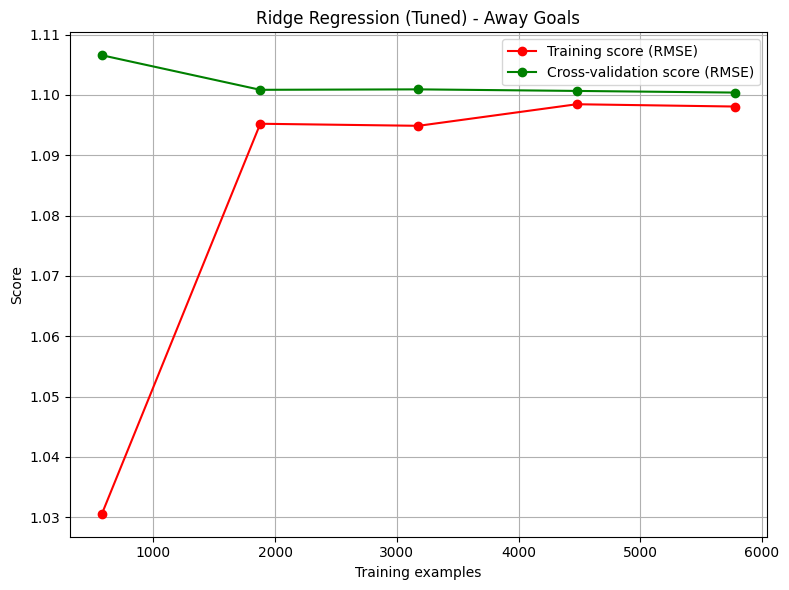

In [182]:
# Definisi parameter space untuk Ridge
ridge_params = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100],  # Kekuatan regularisasi
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}

# Grid Search dengan cross-validation
ridge_search = GridSearchCV(
    Ridge(),
    ridge_params,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)
ridge_search.fit(X_train, y_train_away)

# Hasil terbaik
print("=== Ridge Regression Best Params ===")
print(f"Best RMSE: {-ridge_search.best_score_:.3f}")
print(f"Best Params: {ridge_search.best_params_}")

# Plot learning curve model terbaik
# Corrected the order of arguments: title, X, y
plot_learning_curve(ridge_search.best_estimator_, 'Ridge Regression (Tuned) - Away Goals', X_train, y_train_away)


=== Neural Network Best Params ===
Best RMSE: 1.102
Best Params: {'activation': 'logistic', 'alpha': np.float64(0.0030009621461129445), 'batch_size': 128, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001, 'max_iter': 500}


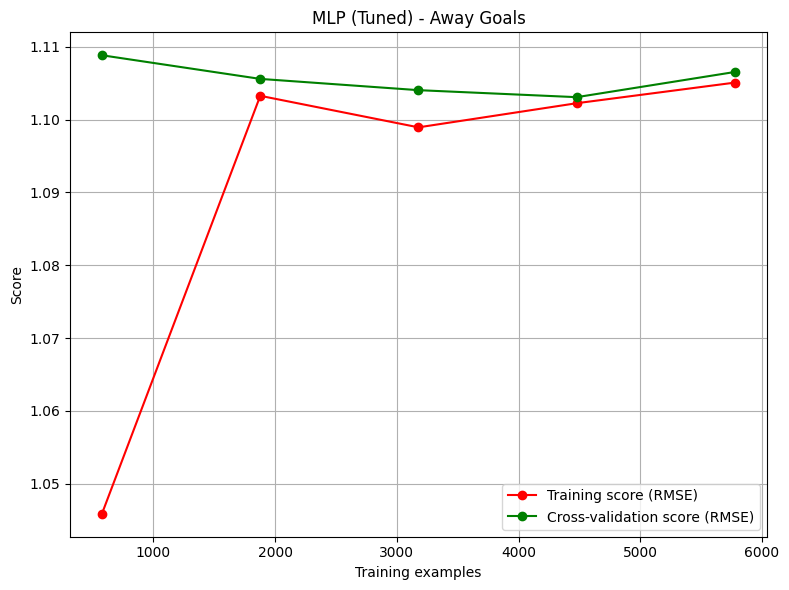

In [183]:
# Definisi parameter space untuk MLP
mlp_params = {
    'hidden_layer_sizes': [(50,), (100,), (50,50), (100,50)],  # Arsitektur jaringan
    'activation': ['relu', 'tanh', 'logistic'],
    'alpha': loguniform(1e-5, 1),  # Regularisasi L2
    'learning_rate_init': [0.001, 0.01, 0.1],
    'batch_size': [32, 64, 128],
    'max_iter': [500, 1000]
}

# Randomized Search (lebih efisien untuk NN)
mlp_search = RandomizedSearchCV(
    MLPRegressor(random_state=42),
    mlp_params,
    n_iter=30,
    cv=3,  # Cross-validation lebih kecil karena komputasi berat
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)
mlp_search.fit(X_train, y_train_away)

# Hasil terbaik
print("\n=== Neural Network Best Params ===")
print(f"Best RMSE: {-mlp_search.best_score_:.3f}")
print(f"Best Params: {mlp_search.best_params_}")

# Plot learning curve model terbaik
# Corrected the order of arguments: title, X, y
plot_learning_curve(mlp_search.best_estimator_, 'MLP (Tuned) - Away Goals', X_train, y_train_away)

In [184]:
# Evaluasi pada evaluation set (bukan test set)
ridge_best = ridge_search.best_estimator_
# Pastikan MLP best estimator juga sudah dilatih pada data training full
# Meskipun RandomizedSearchCV melatih model terakhir, ini untuk kejelasan
mlp_best = mlp_search.best_estimator_


print("\n=== Performance on Evaluation Set ===")
# Use X_eval and y_eval_home for evaluation
print("Ridge - Home Goals RMSE (Eval):", np.sqrt(mean_squared_error(y_eval_home, ridge_best.predict(X_eval))))
# Use X_eval and y_eval_away for evaluation
print("MLP - Away Goals RMSE (Eval):", np.sqrt(mean_squared_error(y_eval_away, mlp_best.predict(X_eval))))

print("\n=== Baseline (Default Params) Performance on Evaluation Set ===")
# Re-train default models on the *same* training data (X_train) for comparison
default_ridge = Ridge().fit(X_train, y_train_home)
default_mlp = MLPRegressor(random_state=42).fit(X_train, y_train_away)

# Evaluate default models on the *same* evaluation data (X_eval)
print("Ridge Default RMSE (Eval):", np.sqrt(mean_squared_error(y_eval_home, default_ridge.predict(X_eval))))
print("MLP Default RMSE (Eval):", np.sqrt(mean_squared_error(y_eval_away, default_mlp.predict(X_eval))))


=== Performance on Evaluation Set ===
Ridge - Home Goals RMSE (Eval): 1.5655152749346204
MLP - Away Goals RMSE (Eval): 1.0683398795381538

=== Baseline (Default Params) Performance on Evaluation Set ===
Ridge Default RMSE (Eval): 1.277554156057278
MLP Default RMSE (Eval): 1.0702297744459988


In [185]:
# Contoh: Cari prediksi untuk pertandingan spesifik (bisa input nama team)
specific_match = submission_df[
    (submission_df['HomeTeam'] == 'Man United') &
    (submission_df['AwayTeam'] == 'Man City')
]
print("\nPrediksi untuk Man Utd vs Man City:")
print(specific_match.to_string(index=False))


Prediksi untuk Man Utd vs Man City:
 Season  MatchDate   HomeTeam AwayTeam  PredictedHomeGoals  PredictedAwayGoals PredictedFullTime  HomeWinProbability  DrawProbability  AwayWinProbability
2024/25 2025-04-06 Man United Man City                   3                   0                 H               0.482            0.236               0.282


In [189]:
# Simpan ke file CSV
submission_file_path = 'epl_score_predictions_submission.csv'
submission_df.to_csv(submission_file_path, index=False)

print(f"Submission file telah disimpan ke: {submission_file_path}")
print(f"Jumlah prediksi yang disimpan: {len(submission_df)}")

Submission file telah disimpan ke: epl_score_predictions_submission.csv
Jumlah prediksi yang disimpan: 380


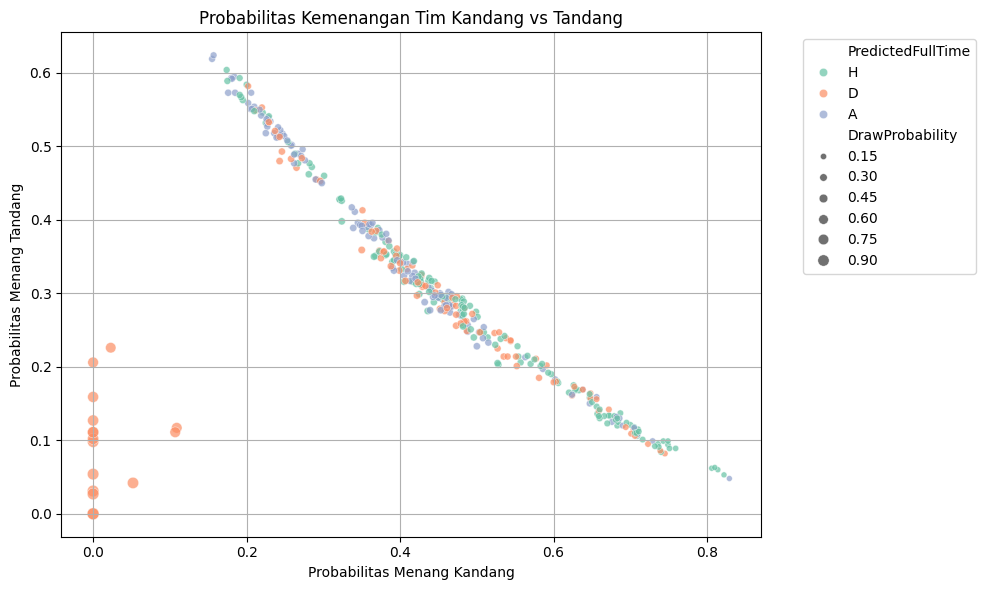

In [190]:
# Visualisasi probabilitas
plt.figure(figsize=(10, 6))
sns.scatterplot(data=test_df,
               x='HomeWinProbability',
               y='AwayWinProbability',
               hue='PredictedFullTime',
               size='DrawProbability',
               palette='Set2',
               alpha=0.7)
plt.title('Probabilitas Kemenangan Tim Kandang vs Tandang')
plt.xlabel('Probabilitas Menang Kandang')
plt.ylabel('Probabilitas Menang Tandang')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

<ipython-input-194-3351b31007e0>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_df, x='FullTimeResult', palette='Set2')
<ipython-input-194-3351b31007e0>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=predict_df, x='PredictedFullTime', palette='Set2') # Use 'PredictedFullTime' from the prediction df


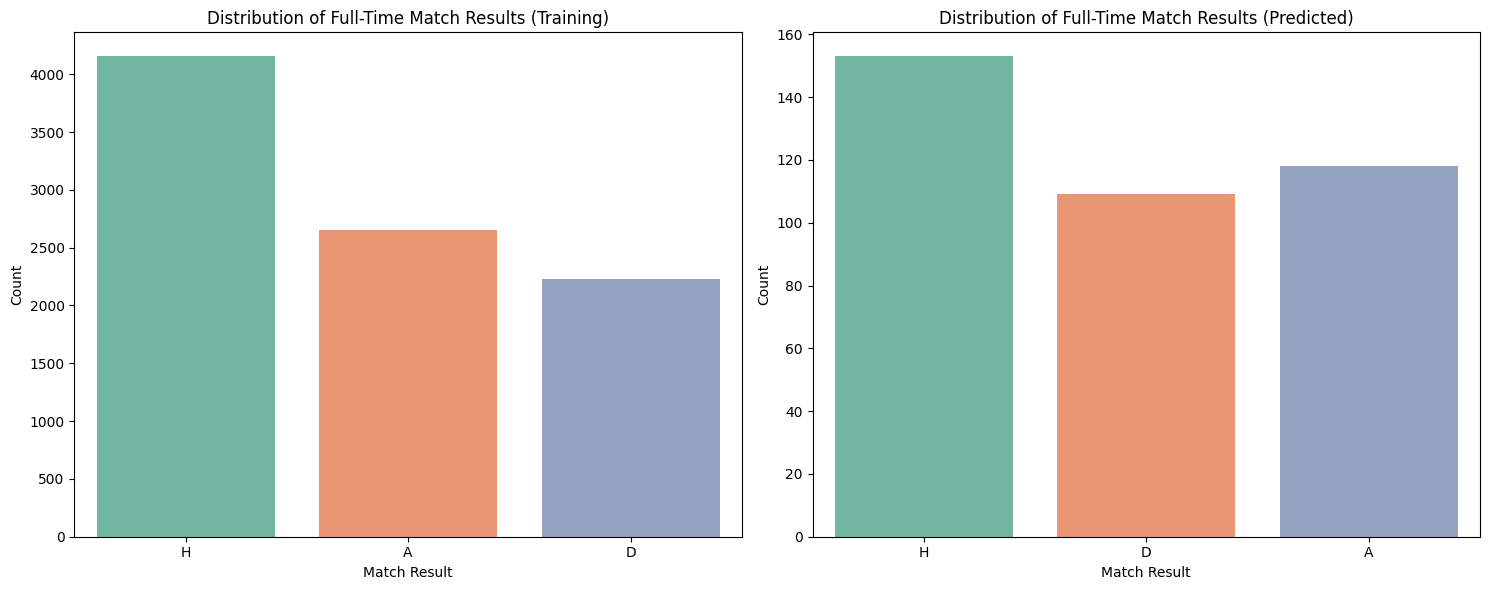

In [194]:
plt.figure(figsize=(15, 6))

# Read the CSV file into a pandas DataFrame
predict_df = pd.read_csv("/content/epl_score_predictions_submission.csv")

# --- Count Plot: FullTimeResult ---
plt.subplot(1, 2, 1)
sns.countplot(data=train_df, x='FullTimeResult', palette='Set2')
plt.title('Distribution of Full-Time Match Results (Training)')
plt.xlabel('Match Result')
plt.ylabel('Count')

# --- Count Plot: FullTimeResult --- (Predict)
plt.subplot(1, 2, 2) # Changed to subplot 2 to not overlap the first plot
sns.countplot(data=predict_df, x='PredictedFullTime', palette='Set2') # Use 'PredictedFullTime' from the prediction df
plt.title('Distribution of Full-Time Match Results (Predicted)')
plt.xlabel('Match Result')
plt.ylabel('Count')

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()


Probabilitas Menang Kandang per Tim:
HomeTeam
Liverpool     0.654000
Man United    0.641294
Chelsea       0.615737
Man City      0.615053
Arsenal       0.613895
Tottenham     0.534000
Everton       0.453737
Newcastle     0.434944
Ipswich       0.420444
Brentford     0.417053
Name: HomeWinProbability, dtype: float64


<ipython-input-195-7924f8b8ed5f>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_home_teams.values, y=top_home_teams.index, palette='Blues_d')


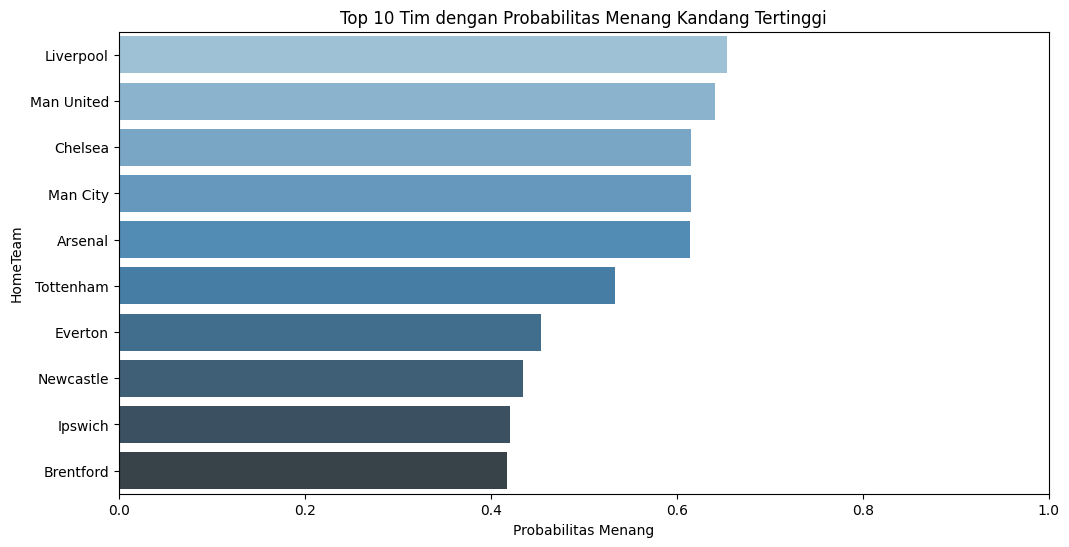

In [195]:
# Contoh: Hitung probabilitas kemenangan rata-rata tiap tim
team_analysis = submission_df.groupby('HomeTeam')['HomeWinProbability'].mean().sort_values(ascending=False)
print("\nProbabilitas Menang Kandang per Tim:")
print(team_analysis.head(10))

# Visualisasi top 10 tim dengan probabilitas menang kandang tertinggi
top_home_teams = submission_df.groupby('HomeTeam')['HomeWinProbability'].mean().nlargest(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_home_teams.values, y=top_home_teams.index, palette='Blues_d')
plt.title('Top 10 Tim dengan Probabilitas Menang Kandang Tertinggi')
plt.xlabel('Probabilitas Menang')
plt.xlim(0, 1)
plt.show()

In [196]:
# Membuat submission file final
submission_df = test_df[['Season', 'MatchDate', 'HomeTeam', 'AwayTeam',
                        'PredictedHomeGoals', 'PredictedAwayGoals', 'PredictedFullTime',
                        'HomeWinProbability', 'DrawProbability', 'AwayWinProbability']].copy()

In [197]:
# Format kolom MatchDate
submission_df['MatchDate'] = pd.to_datetime(submission_df['MatchDate']).dt.strftime('%Y-%m-%d')

# Reorder kolom untuk tampilan lebih baik
submission_df = submission_df[['Season', 'MatchDate', 'HomeTeam', 'AwayTeam',
                              'PredictedHomeGoals', 'PredictedAwayGoals', 'PredictedFullTime',
                              'HomeWinProbability', 'DrawProbability', 'AwayWinProbability']]

# Simpan ke file CSV
submission_file_path = 'epl_predictions_final_submission.csv'
submission_df.to_csv(submission_file_path, index=False)

In [198]:
# Membuat klasemen berdasarkan hasil prediksi
teams = {}

for _, row in submission_df.iterrows():
    home = row['HomeTeam']
    away = row['AwayTeam']
    hg = int(row['PredictedHomeGoals'])
    ag = int(row['PredictedAwayGoals'])

    # Inisialisasi jika tim belum ada
    for team in [home, away]:
        if team not in teams:
            teams[team] = {'MP': 0, 'W': 0, 'D': 0, 'L': 0, 'GF': 0, 'GA': 0, 'Pts': 0}

    # Update pertandingan
    teams[home]['MP'] += 1
    teams[away]['MP'] += 1
    teams[home]['GF'] += hg
    teams[home]['GA'] += ag
    teams[away]['GF'] += ag
    teams[away]['GA'] += hg

    # Menentukan hasil
    if hg > ag:
        teams[home]['W'] += 1
        teams[away]['L'] += 1
        teams[home]['Pts'] += 3
    elif hg < ag:
        teams[away]['W'] += 1
        teams[home]['L'] += 1
        teams[away]['Pts'] += 3
    else:
        teams[home]['D'] += 1
        teams[away]['D'] += 1
        teams[home]['Pts'] += 1
        teams[away]['Pts'] += 1

# Ubah ke DataFrame
league_table = pd.DataFrame.from_dict(teams, orient='index')
league_table['GD'] = league_table['GF'] - league_table['GA']
league_table = league_table.sort_values(by=['Pts', 'GD', 'GF'], ascending=False)

# Tambah peringkat
league_table.insert(0, 'Rank', range(1, len(league_table)+1))

# Tampilkan klasemen
print("\n=== Klasemen Liga Berdasarkan Prediksi ===")
print(league_table.head(20))  # Top 20 tim



=== Klasemen Liga Berdasarkan Prediksi ===
                Rank  MP   W   D   L  GF  GA  Pts  GD
Liverpool          1  38  22   9   7  69  30   75  39
Man United         2  35  22   6   7  78  40   72  38
Chelsea            3  38  20  12   6  66  34   72  32
Man City           4  38  18  10  10  67  46   64  21
Southampton        5  38  15  16   7  52  33   61  19
Arsenal            6  38  16   9  13  60  47   57  13
Brighton           7  38  17   5  16  48  53   56  -5
Newcastle          8  36  14  13   9  60  55   55   5
Ipswich            9  36  14  11  11  53  50   53   3
Crystal Palace    10  38  12  11  15  35  42   47  -7
Aston Villa       11  38  12  10  16  46  44   46   2
Tottenham         12  35  12   9  14  46  55   45  -9
Leicester         13  36  12   8  16  46  48   44  -2
West Ham          14  38  12   8  18  39  61   44 -22
Fulham            15  38  10  13  15  49  63   43 -14
Wolves            16  38  10  11  17  36  56   41 -20
Everton           17  38   9  11  18  